In [ ]:
!ls /moredata/gsantos/canard/onts

In [1]:
from om.match import onts, aligns
from om.ont import split_entity, pt, remove_bn
from om.util import Cross
from termcolor import colored
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from tqdm.notebook import tqdm
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
import matplotlib.pyplot as plt
from om.match import Runner, print_result, Step
from om.util import Cross, get_vocab, WordMap
import math
import random
import pandas as pd
from om.ont import get_n, noisy_copy, remove_bn
from rdflib import Graph, URIRef, BNode, Literal, Namespace
from rdflib.namespace import RDF, RDFS, OWL
import os
from pymagnitude import *
from gensim.parsing.preprocessing import STOPWORDS
import math
import os

/home/guilherme/PycharmProjects/kgome/venv/lib/python3.9/site-packages/om/ont.py:7: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [65]:
class MDataset(Dataset):

    def __init__(self, dtsn, als, g1, g2, tb=1, fb=1, cache=False, cacheLen=500000):
        self.transform = None
        self.cache = cache
        self.cacheLen = cacheLen
        self.dtsn = dtsn + '-cache.bin'
        if os.path.exists(self.dtsn):
            os.remove(self.dtsn)

        self.g1 = g1
        self.g2 = g2
        self.als = als

        with torch.no_grad():
            self.ents1, self.adj1, self.pdj1 = build_adj(self.g1)
            self.ents2, self.adj2, self.pdj2 = build_adj(self.g2)

        tc = 0
        nc = 0
        self.data = []
        self.dl = 0
        self.li = -1 if self.cache else 0
        self.mi = -1

        for e1 in tqdm(set(self.g1.subjects())):
            for e2 in set(self.g2.subjects()):
                if random.random() < (1 - fb):
                    continue
                sim = torch.Tensor([1 if (e1, e2) in self.als else -1])

                for _ in range(1 if sim != 1 else tb):
                    if sim != 1:
                        nc += 1
                    else:
                        tc += 1
                    self.dl += 1

                    self.data.append((e1, e2, sim))

                    if self.cache and len(self.data) >= self.cacheLen:
                        random.shuffle(self.data)
                        self._cache()
                        self.data = []

        if self.cache:
            random.shuffle(self.data)
            self._cache()
            self.data = []

        print(f'{len(self)} instances. {tc} true, {nc} false.')

    def _cache(self):
        lines = []
        for e1, e2, s in self.data:
            lines.append(str(e1).encode('utf-8').ljust(500) + str(e2).encode('utf-8').ljust(500) + str(s.item()).encode(
                'utf-8').ljust(50))

        with open(self.dtsn, 'ab') as f:
            f.writelines(lines)

    def _loadblock(self, i, ml):
        self.data = []
        ls = 500 + 500 + 50

        with open(self.dtsn, 'rb') as f:
            f.seek(i * ls)
            rd = f.read(ml * ls)

        for fi in range(ml):
            line = rd[fi * ls:(fi + 1) * ls]
            u1 = line[:500].decode('utf-8').strip()
            u2 = line[500:1000].decode('utf-8').strip()
            s = line[1000:1050].decode('utf-8').strip()

            self.data.append((URIRef(u1), URIRef(u2), torch.Tensor([float(s)])))

        self.li = i
        self.mi = i + ml

    def __getitem__(self, i):
        if self.cache and (i >= self.mi or i < self.li):
            self._loadblock(i, min(self.dl - i, 200000))

        return self.data[i - self.li]

    def __len__(self):
        return self.dl


class MatchDataset(MDataset):

    def __init__(self, r, o1, o2, tb=1):
        g1 = Graph()
        g1.parse(o1)
        g2 = Graph()
        g2.parse(o2)

        als = set(map(lambda x: (URIRef(x[0]), URIRef(x[1])), aligns(r)))

        super().__init__('none', als, g1, g2, tb=tb)


In [2]:
def build_adj(g):
    ents = list(get_vocab(g))

    random.shuffle(ents)
    l = len(ents)
    adj = torch.zeros((l, l))
    pdj = -torch.ones((l, l))

    wm = WordMap(ents)

    for s, p, o in g:

        adj[wm[s]][wm[o]] = 1
        pdj[wm[s]][wm[o]] = wm[p]

        if (s, RDFS.domain, None) in g and (s, RDFS.range, None) in g:
            domain = g.value(s, RDFS.domain)
            rg = g.value(s, RDFS.range)

            adj[wm[domain]][wm[rg]] = 1
            pdj[wm[s]][wm[o]] = wm[s]

            adj[wm[rg]][wm[domain]] = -1
            pdj[wm[rg]][wm[domain]] = wm[s]

        if (s, RDFS.subClassOf, None) in g:
            for ob in g.objects(s, RDFS.subClassOf):
                adj[wm[s]][wm[ob]] = 1
                pdj[wm[s]][wm[ob]] = wm[RDFS.subClassOf]

                adj[wm[ob]][wm[s]] = -1
                pdj[wm[ob]][wm[s]] = wm[RDFS.subClassOf]

    return ents, adj, pdj.long()


def build_adj_lstc(g):
    ents = list(get_vocab(g))

    random.shuffle(ents)
    l = len(ents)
    adj = dict()
    pdj = dict()

    wm = WordMap(ents)

    for s, p, o in g:

        adj.setdefault(wm[s], dict())[wm[o]] = 1
        pdj.setdefault(wm[s], dict())[wm[o]] = wm[p]

        if (s, RDFS.domain, None) in g and (s, RDFS.range, None) in g:
            domain = g.value(s, RDFS.domain)
            rg = g.value(s, RDFS.range)

            adj.setdefault(wm[domain], dict())[wm[rg]] = 1
            pdj[wm[s]][wm[o]] = wm[s]

            adj.setdefault(wm[rg], dict())[wm[domain]] = -1
            pdj.setdefault(wm[rg], dict())[wm[domain]] = wm[s]

        if (s, RDFS.subClassOf, None) in g:
            for ob in g.objects(s, RDFS.subClassOf):
                adj[wm[s]][wm[ob]] = 1
                pdj[wm[s]][wm[ob]] = wm[RDFS.subClassOf]

                adj.setdefault(wm[ob], dict())[wm[s]] = -1
                pdj.setdefault(wm[ob], dict())[wm[s]] = wm[RDFS.subClassOf]

    return ents, adj, pdj


In [4]:
g1 = Graph()
g1.parse('conference/cmt.owl')

remove_bn(g1)

g2 = Graph()
g2.parse('conference/confOf.owl')

remove_bn(g2)

g3 = Graph()
g3.parse('conference/Conference.owl')

remove_bn(g3)

g4 = Graph()
g4.parse('conference/edas.owl')

remove_bn(g4)

g5 = Graph()
g5.parse('conference/ekaw.owl')

remove_bn(g5)

g6 = Graph()
g6.parse('conference/iasted.owl')

remove_bn(g6)

g7 = Graph()
g7.parse('conference/sigkdd.owl')

remove_bn(g7)

als1 = set(map(lambda x: (x, x), set(g1.subjects())))
als2 = set(map(lambda x: (x, x), set(g2.subjects())))
als3 = set(map(lambda x: (x, x), set(g3.subjects())))
als4 = set(map(lambda x: (x, x), set(g4.subjects())))
als5 = set(map(lambda x: (x, x), set(g5.subjects())))
als6 = set(map(lambda x: (x, x), set(g6.subjects())))
als7 = set(map(lambda x: (x, x), set(g7.subjects())))

datasets = [
    MDataset('dts1', als1, g1, g1, tb=90, fb=1, cache=False),
    MDataset('dts1', als2, g2, g2, tb=90, fb=1, cache=False),
    MDataset('dts1', als3, g3, g3, tb=150, fb=1, cache=False),
    MDataset('dts1', als4, g4, g4, tb=280, fb=1, cache=False),
    MDataset('dts1', als5, g5, g5, tb=150, fb=1, cache=False),
    MDataset('dts1', als6, g6, g6, tb=250, fb=1, cache=False),
    MDataset('dts1', als7, g7, g7, tb=150, fb=1, cache=False)
]

  0%|          | 0/99 [00:00<?, ?it/s]

18612 instances. 8910 true, 9702 false.


  0%|          | 0/99 [00:00<?, ?it/s]

18612 instances. 8910 true, 9702 false.


  0%|          | 0/155 [00:00<?, ?it/s]

47120 instances. 23250 true, 23870 false.


  0%|          | 0/297 [00:00<?, ?it/s]

171072 instances. 83160 true, 87912 false.


  0%|          | 0/124 [00:00<?, ?it/s]

33852 instances. 18600 true, 15252 false.


  0%|          | 0/247 [00:00<?, ?it/s]

122512 instances. 61750 true, 60762 false.


  0%|          | 0/89 [00:00<?, ?it/s]

21182 instances. 13350 true, 7832 false.


In [8]:
class GNAH(nn.Module):

    def __init__(self, emblen):
        super().__init__()
        self.emblen = emblen
        self.w = nn.Linear(emblen, emblen, bias=False)
        self.a = nn.Linear(emblen * 2, 1)
        self.lrelu = nn.LeakyReLU(negative_slope=0.2)
        self.pc = nn.Linear(emblen * 2, emblen)



    def run_lst(self, embs, adj, device=torch.device('cpu')):

        res = dict()

        for e in adj:
            adje = list(map(lambda x: torch.cat([embs[x[0]], embs[x[1]]], dim=1) * x[2], adj[e]))
            adje = torch.cat(adje).to(device)
            adje = self.lrelu(self.pc(adje))
            pc = self.w(adje)
            embe = embs[e].to(device)
            wf = self.w(embe)
            rm = wf.repeat(pc.shape[0], 1)

            mf = self.lrelu(self.a(torch.cat([rm, pc], dim=1)))
            mf = torch.softmax(mf, dim=1)

            cf = adje * mf
            cf = torch.sum(cf, dim=0, keepdim=True)
            res[e] = torch.cat([embe, cf], dim=1)

        return res

    def run_lsta(self, embs, adj, pde, device=torch.device('cpu')):
        res = dict()

        for i in range(len(embs)):
            n = []
            p = []
            h = embs[i].unsqueeze(0)
            if i in adj:

                for k in adj[i]:
                    n.append(embs[k].unsqueeze(0))
                    if k in pde[i]:
                        p.append(embs[pde[i][k]].unsqueeze(0))
                    else:
                        p.append(torch.zeros((1, 300)).to(device))

                n = torch.cat(n)
                p = torch.cat(p)

                pcq = self.w(self.lrelu(self.pc(torch.cat([self.w(n.to(device)), p.to(device)], dim=1))))
                mfq = self.lrelu(self.a(torch.cat([self.w(h.repeat(pcq.shape[0], 1).to(device)), pcq], dim=1)))
                mfq = torch.softmax(mfq, dim=0)
                cemb = torch.sum(mfq * n.to(device), dim=0, keepdim=True)
            else:
                cemb = torch.zeros((1, 300)).to(device)
            res[i] = torch.cat([h.to(device), cemb], dim=1)

        return res


class MHAG(nn.Module):

    def __init__(self, emblen, heads):
        super().__init__()
        self.emblen = emblen
        self.heads = nn.ModuleList([GNAH(emblen) for _ in range(heads)])
        self.ch = nn.Linear(emblen * heads * 2, emblen)

    def run_lst(self, embs, adj, device=torch.device('cpu')):
        res = [h.run_lst(embs, adj, device) for h in self.heads]

        rm = dict()
        for r in res:
            for e in r:
                rm.setdefault(e, []).append(r[e])


        for e in rm:
            ce = torch.cat(rm[e], dim=1)
            ce = self.ch(ce)
            rm[e] = ce

        return rm


    def run_lsta(self, embs, adj, pdj, device=torch.device('cpu')):
        res = [h.run_lsta(embs, adj, pdj, device) for h in self.heads]

        rm = dict()
        for r in res:
            for e in r:
                rm.setdefault(e, []).append(r[e])


        for e in rm:
            ce = torch.cat(rm[e], dim=1)
            ce = self.ch(ce)
            rm[e] = ce

        return rm


class GNN(nn.Module):

    def __init__(self, emblen, heads, nodes):
        super().__init__()
        self.emblen = emblen
        self.heads = heads
        self.nodes = nodes
        self.an = nn.ModuleList([MHAG(emblen, heads) for _ in range(nodes)])


    def run_lst(self, embs, adj, device=torch.device('cpu')):
        res = embs

        for n in self.an:
            res = n.run_lst(res, adj, device)

        return res


    def run_lsta(self, embs, adj, pdj, device=torch.device('cpu')):
        res = embs

        for n in self.an:
            res = n.run_lsta(embs, adj, pdj, device)

        return res




class KGOME:

    def __init__(self):
        self.glove = Magnitude('/home/guilherme/Documents/kg/glove.magnitude')
        self.emblen = 300
        pass


    def load(self, path):
        self.gnn = GNN(self.emblen, 2, 1)
        self.gnn.load_state_dict(torch.load(path, map_location=torch.device('cpu')))


    def emb_ents(self, ents, g):
        embs = []

        for i in range(len(ents)):
            e = ents[i]

            if type(e) is BNode:
                emb = torch.zeros((1, 300))

            elif type(e) is Literal:
                words = split_entity(e)
                if len(words) > 0:
                    emb = sum(map(lambda x: torch.Tensor([list(self.glove.query(x.lower()))]), words)) / len(words)
                else:
                    emb = torch.zeros((1, 300))
            else:

                n = e.n3(g.namespace_manager)
                if n.startswith('<'):
                    n = n.split('/')[-1]
                else:
                    n = n.split(':')[-1]

                words = split_entity(n)
                if len(words) > 0:
                    emb = sum(map(lambda x: torch.Tensor([list(self.glove.query(x.lower()))]), words)) / len(words)
                else:
                    emb = torch.zeros((1, 300))
            embs.append(emb)
        return torch.cat(embs)



    def build_lst(self, g):
        res = dict()

        for s, p, o in g:
            res.setdefault(s, set()).add((p, o, 1))

            if (s, RDFS.domain, None) in g and (s, RDFS.range, None) in g:
                domain = g.value(s, RDFS.domain)
                rg = g.value(s, RDFS.range)

                res.setdefault(domain, set()).add((s, rg, 1))
                res.setdefault(rg, set()).add((s, domain, -1))

            if (s, RDFS.subClassOf, None) in g:
                for ob in g.objects(s, RDFS.subClassOf):
                    res.setdefault(s, set()).add((RDFS.subClassOf, ob, 1))
                    res.setdefault(ob, set()).add((RDFS.subClassOf, s, -1))

        return res


    def embed_lsta(self, g, device=torch.device('cpu')):
        ents1, adj1, pdj1 = build_adj_lstc(g)

        embs1 = self.emb_ents(ents1, g)

        self.gnn.to(device)
        with torch.no_grad():
            m1 = self.gnn.run_lsta(embs1.to(device), adj1, pdj1)

        return ents1, m1


    def split_filter(self, text):
        words = set(split_entity(text))
        words_lower = map(lambda x: x.lower(), words)
        words_filter = filter(lambda x: x not in STOPWORDS and not x.isdigit(), words_lower)
        return list(words_filter)

    def embed_sentence(self, words):
        result = []

        for word in words:
            emb = self.glove.query(word)
            emb = torch.Tensor([list(emb)])
            result.append(emb)

        return torch.cat(result, dim=0).mean(dim=0, keepdim=True)


    def emb_ents_lst(self, ents, g, device=torch.device('cpu')):
        embs = dict()

        for e in ents:

            if type(e) is BNode:
                emb = torch.zeros((1, 300))

            elif type(e) is Literal:
                words = split_entity(e)
                emb = sum(map(lambda x: torch.Tensor([list(self.glove.query(x.lower()))]), words)) / len(words)
            else:

                n = e.n3(g.namespace_manager)
                if n.startswith('<'):
                    n = n.split('/')[-1]
                else:
                    n = n.split(':')[-1]

                words = split_entity(n)
                if len(words) <= 0:
                    emb = torch.zeros((1, 300))
                else:
                    emb = sum(map(lambda x: torch.Tensor([list(self.glove.query(x.lower()))]), words)) / len(words)

            embs[e] = emb
        return embs


    def fit_lst(self, datasets, device=torch.device('cpu')):

        epochs = 3
        lr = 0.0003

        crit = nn.CosineEmbeddingLoss(margin=0.4)

        self.gnn = GNN(self.emblen, 2, 1)
        self.gnn.to(device)
        optimizer = optim.Adam(self.gnn.parameters(), lr=lr)
        lh = []
        bs = 256
        sizes = sum(map(lambda x: math.ceil(len(x) / bs), datasets))
        sizes *= epochs
        progress = tqdm(total=sizes)

        for epcq in range(epochs):
            el = 0
            for data in datasets:

                dl = 0


                ents1 = get_vocab(data.g1)
                ents2 = get_vocab(data.g1)
                embs1 = self.emb_ents_lst(ents1, data.g1)
                embs2 = self.emb_ents_lst(ents2, data.g2)
                adjm1 = self.build_lst(data.g1)
                adjm2 = self.build_lst(data.g2)

                for e1, e2, s in DataLoader(data, batch_size=bs):
                    optimizer.zero_grad()

                    m1 = self.gnn.run_lst(embs1, adjm1, device)
                    m2 = self.gnn.run_lst(embs2, adjm2, device)

                    r1 = list(map(lambda x: m1[x], e1))
                    r2 = list(map(lambda x: m2[x], e2))

                    r1 = torch.cat(r1).to(torch.device('cpu'))
                    r2 = torch.cat(r2).to(torch.device('cpu'))

                    loss = crit(r1, r2, s.flatten())
                    loss.backward()

                    optimizer.step()
                    dl += loss.item()

                    progress.update(1)
                    # break

                dl /= (len(data) / bs)
                el += dl

                # break

            el /= len(datasets)
            lh.append(el)
            torch.save(self.gnn.state_dict(), f'gnn-conf-{epcq}.pt')
            # break

        plt.plot(lh)
        plt.show()


In [9]:
kgome = KGOME()
kgome.load('gnn-cp-conf-2.pt')

  0%|          | 0/5085 [00:00<?, ?it/s]

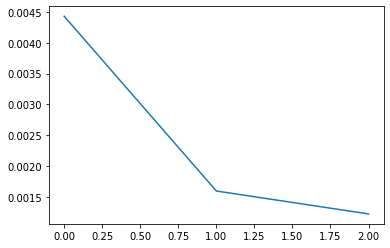

In [51]:
kgome.fit_lst(datasets)

In [5]:
def eval_result(result, rang):
    if len(result) <= 1:
        result[0].drop('name', axis=1).mean().plot.bar(rot=0)
        f = [0]
    else:
        p = []
        r = []
        f = []

        for q in result:
            v = q.drop('name', axis=1).mean()

            p.append(v['precision'])
            r.append(v['recall'])
            f.append(v['f1'])

        plt.figure(figsize=(10, 5))
        plt.plot(rang, p, c='r')
        plt.plot(rang, r, c='g')
        plt.plot(rang, f, c='b')
        plt.show()

    print(rang[np.argmax(f)])
    print_result(result[np.argmax(f)])

    rd = dict()

    for n in result[0]['name'].unique():
        l = result[0][result[0]['name'] == n].copy()
        l['th'] = 0
        rd[n] = l

    for i in range(len(rang)):
        for n in result[i]['name'].unique():
            l = result[i][result[i]['name'] == n].copy()
            l['th'] = rang[i]

            if l['f1'].iloc[0] > rd[n]['f1'].iloc[0]:
                rd[n] = l

    print('\n\noracle th ---------------------')
    print_result(pd.concat(rd.values()))





In [10]:
rang = np.arange(0.1, 1, 0.01)

class LstMatcher(Step):

    def __init__(self):
        self.cross = Cross()

    def forward(self, dataset, i):
        ents = self.cross(dataset)

        kgome.gnn.to(torch.device('cpu'))
        with torch.no_grad():
            ents1, m1 = kgome.embed_lsta(dataset.g1)
            ents2, m2 = kgome.embed_lsta(dataset.g2)

        wi1 = WordMap(ents1)
        wi2 = WordMap(ents2)

        res = [[] for r in rang]
        for e1, e2 in ents:

            r1 = m1[wi1[e1]]
            r2 = m2[wi2[e2]]
            s = F.cosine_similarity(r1, r2)
            s = s.item()
            for i in range(len(rang)):
                sim = 1 if s > rang[i] else 0
                res[i].append((e1, e2, sim))

        return res, {}



kgome


  0%|          | 0/21 [00:00<?, ?it/s]

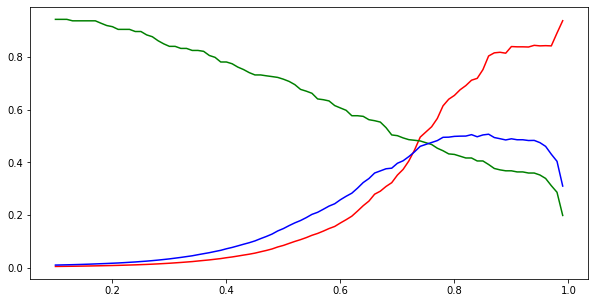

0.8599999999999995
                     name  precision    recall        f1
0   conference-iasted.rdf   0.666667  0.166667  0.266667
1         ekaw-iasted.rdf   0.857143  0.428571  0.571429
2      cmt-conference.rdf   0.750000  0.250000  0.375000
3          cmt-iasted.rdf   0.800000  1.000000  0.888889
4         confOf-ekaw.rdf   0.846154  0.379310  0.523810
5           edas-ekaw.rdf   0.647059  0.314286  0.423077
6       confOf-iasted.rdf   0.833333  0.384615  0.526316
7     conference-ekaw.rdf   0.714286  0.250000  0.370370
8            cmt-ekaw.rdf   0.833333  0.294118  0.434783
9         edas-iasted.rdf   0.875000  0.225806  0.358974
10        edas-sigkdd.rdf   1.000000  0.304348  0.466667
11         cmt-confOf.rdf   0.571429  0.142857  0.228571
12      confOf-sigkdd.rdf   1.000000  0.400000  0.571429
13        ekaw-sigkdd.rdf   1.000000  0.466667  0.636364
14         cmt-sigkdd.rdf   0.800000  0.500000  0.615385
15    conference-edas.rdf   0.666667  0.416667  0.512821
16          

In [11]:
print('=' * 100)
print('kgome')
print('=' * 100)

runner = Runner('conference', 'reference', matcher=LstMatcher())
result = runner.run(parallel=False)

eval_result(result, rang)

In [ ]:
class GloveMatcher(Step):

    def __init__(self):
        self.cross = Cross()
        self.glove = kgome.glove

    def forward(self, dataset, i):
        g1 = dataset.g1
        g2 = dataset.g2

        remove_bn(g1)
        remove_bn(g2)

        ents1 = set(g1.subjects())
        ents2 = set(g2.subjects())

        m1 = dict()

        for e1 in ents1:
            n1 = e1.n3(g1.namespace_manager)
            n1 = map(lambda x: x.lower(), split_entity(n1))
            n1 = list(map(lambda x: torch.Tensor([list(self.glove.query(x.lower()))]), n1))
            ln = len(n1)
            sv = sum(n1) / ln

            m1[e1] = sv.squeeze(0)

        m2 = dict()

        for e1 in ents2:
            n1 = e1.n3(g2.namespace_manager)
            n1 = map(lambda x: x.lower(), split_entity(n1))
            n1 = list(map(lambda x: torch.Tensor([list(self.glove.query(x.lower()))]), n1))
            ln = len(n1)
            sv = sum(n1) / ln

            m2[e1] = sv.squeeze(0)

        ents = self.cross(dataset)

        res = [[] for r in rang]
        for e1, e2 in ents:

            r1 = m1[e1]
            r2 = m2[e2]

            s = F.cosine_similarity(r1.unsqueeze(0), r2.unsqueeze(0)).item()
            for i in range(len(rang)):
                sim = 1 if s > rang[i] else 0
                res[i].append((e1, e2, sim))

        return res, {}

In [ ]:
print('=' * 100)
print('glove')
print('=' * 100)

runner = Runner('/moredata/gsantos/canard/conference', '/moredata/gsantos/canard/reference', matcher=GloveMatcher())
result = runner.run(parallel=False)
eval_result(result, rang)

In [76]:
base = '/home/guilherme/IdeaProjects/conference-dataset-population-elodie/populated_datasets/data_100'

In [82]:
for p, d, f in os.walk(base):
    for file in tqdm(f):
        on = file.split('_')[0]


        g1 = Graph()
        g1.parse(base + f'/{on}_100.ttl')
        g1.bind(f'{on}-instances', Namespace(f'http://{on}-instances#'))
        nf = f'/home/guilherme/Documents/canard/run/kgome/{on}_n.txt'
        ne = f'/home/guilherme/Documents/canard/run/kgome/{on}_e.txt'


        ents, m1 = kgome.embed_lsta(g1)

        nms = []
        ems = []
        for e in tqdm(m1):
          nms.append(ents[e].replace('\n', '\\n') + '\n')
          ems.append(str(list(m1[e][0].numpy()))[1:-1] + '\n')


        with open(nf, 'w') as f:
          f.writelines(nms)

        with open(ne, 'w') as f:
          f.writelines(ems)

        print(len(nms), len(ems))


        with open(nf, 'r') as f:
          nl = f.readlines()

        with open(ne, 'r') as f:
          el = f.readlines()


        print(len(el), len(nl))

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/88260 [00:00<?, ?it/s]

88260 88260
88260 88260


  0%|          | 0/123045 [00:00<?, ?it/s]

123045 123045
123045 123045


  0%|          | 0/82774 [00:00<?, ?it/s]

82774 82774
82774 82774


  0%|          | 0/42807 [00:00<?, ?it/s]

42807 42807
42807 42807


  0%|          | 0/47257 [00:00<?, ?it/s]

47257 47257
47257 47257
